In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import h5py
import numpy as np
from matplotlib import pyplot as plt

# import my script
import sys
sys.path.insert(0, './scripts/') # path to the script folder
from h5_tools import *

# Load data

In [2]:
!ls ./analyzed_runs/p002718

r0280-analysis_000.h5  r0280-setup_000.yml  rois.npy
r0280-analysis_001.h5  r0280-setup_001.yml


In [3]:
filename = './analyzed_runs/p002718/r0280-analysis_001.h5'

Visualize all entries in the h5 file

In [4]:
with h5py.File(filename, 'r') as f:
    f.visititems(visit_func)  

/average
	 /average/image_2d (1, 10, 1358, 1192)
	 /average/intensity (1, 10, 16, 512, 128)
	 /average/train_ids (1,)
	 /average/variance (1, 10, 16, 512, 128)
/identifiers
	 /identifiers/all_trains (946,)
	 /identifiers/complete_trains (921,)
	 /identifiers/filtered_trains (391, 200)
	 /identifiers/pulse_ids (200,)
	 /identifiers/pulses_per_train ()
	 /identifiers/train_ids (821,)
	 /identifiers/train_indices (821,)
/pulse_resolved
/pulse_resolved/azimuthal_intensity
	 /pulse_resolved/azimuthal_intensity/I (391, 200, 256)
	 /pulse_resolved/azimuthal_intensity/phi ()
	 /pulse_resolved/azimuthal_intensity/q (256,)
/pulse_resolved/xgm
	 /pulse_resolved/xgm/energy (391,)
	 /pulse_resolved/xgm/pointing_x (391, 200)
	 /pulse_resolved/xgm/pointing_y (391, 200)
/train_resolved
/train_resolved/correlation
	 /train_resolved/correlation/q (1,)
	 /train_resolved/correlation/stride (3,)
	 /train_resolved/correlation/t (200,)
	 /train_resolved/correlation/ttc (391, 3, 1, 200, 200)
/train_resolved/s

# Intensity

In [5]:
img, Iq, q_bins = get_Iq(filename)

In [6]:
print('img: ', img.shape)
print('Iq: ', Iq.shape) # train, pulse, q_bin
print('q_bins: ', q_bins.shape)

img:  (1358, 1192)
Iq:  (391, 200, 256)
q_bins:  (256,)


<IPython.core.display.Javascript object>


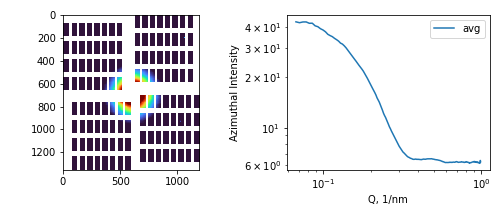

In [7]:
f, (a1,a2) = plt.subplots(1,2, figsize=(7,3), tight_layout=True)

a1.imshow(img, cmap='turbo', vmin=1,vmax=20)

Iq_avg = np.average(Iq,axis=(0,1))
a2.plot(q_bins,Iq_avg, label='avg')

a2.set_xlabel('Q, 1/nm')
a2.set_ylabel('Azimuthal Intensity')
a2.legend()
a2.set_xscale('log')
a2.set_yscale('log')

<IPython.core.display.Javascript object>


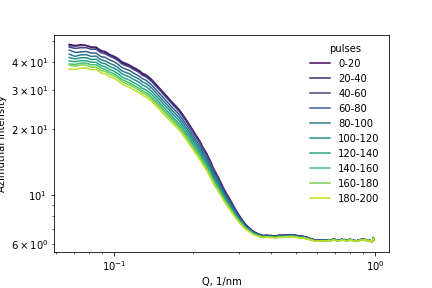

In [8]:
# pulse resolved azimuthal intensity
Iq_pulses = np.average(Iq, axis=0)
train_sel = 10
step = 20

plt.figure()
col = plt.cm.viridis(np.linspace(0,1,Iq.shape[1]))

for i in range(0,Iq.shape[1],step):
    # one train selected with train_sel
    #plt.plot(q_bins, np.average(Iq[train_sel,i:i+step,:],axis=0), c=col[i], label=f'{i}-{i+step}')
    
    # averaged over all trains
    plt.plot(q_bins, np.average(Iq_pulses[i:i+step,:],axis=0), c=col[i], label=f'{i}-{i+step}')
    
plt.xlabel('Q, 1/nm')
plt.ylabel('Azimuthal Intensity')
plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False, title='pulses')
#plt.title(f'Train selected: {train_sel:d}')
plt.show()

# Correlations

In [9]:
ttcs, stride, q, time  = get_correlations(filename, shapes=True)

ttcs:  (391, 3, 1, 200, 200)
stride:  (3,)
q:  (1,)
time:  (200,)


In [10]:
ttc_avg = np.average(ttcs, axis=0)

In [11]:
stride_sel = 1

# averaged over all trains
#ttc = ttc_avg[0,0,:,:] - ttc_avg[stride_sel,0,:,:]

# one train
tr_sel = 100
qs = 0
ttc = ttcs[tr_sel,0,qs,:,:] - ttcs[tr_sel,stride_sel,qs,:,:]
ttc.shape

(200, 200)

<IPython.core.display.Javascript object>


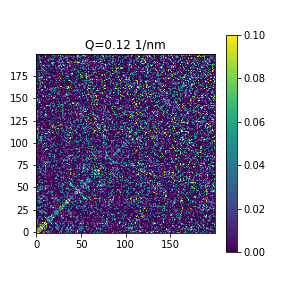

In [12]:
train, corr = 100, 2

plt.figure(figsize=(4,4))

plt.imshow(ttc, origin='lower', vmin=0, vmax=.1)
plt.title(f'Q={q[0]:.2f} 1/nm')
plt.colorbar()

### Calculate the g2 function

<IPython.core.display.Javascript object>


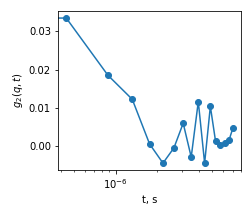

In [13]:
g2 = calculate_g2(ttc)
t_lim = 17

plt.figure(figsize=(3.5,3))
plt.plot(time[:t_lim], g2[:t_lim], 'o-')
plt.xscale('log')
plt.xlabel('t, s')
plt.ylabel(r'$g_2(q,t)$')
plt.tight_layout()

In [14]:
from scipy.optimize import curve_fit

In [15]:
def exponential(x,a,b):
    return np.abs(a) * np.exp( -x/(np.abs(b)) ) + 1

def exponential_kww(x,a,b,c):
    return np.abs(a) * np.exp( -(x/np.abs(b))**c ) + 1

def exponential_kww_offset(x,a,b,c,d):
    return np.abs(a) * np.exp( -(x/np.abs(b))**c ) + d

def fit(function,x,y,p0=None,sigma=None,bounds=[None,None]):
    '''
    fits a function and return the fit resulting parameters and curve
    '''
    popt,pcov = curve_fit(function,x,y,p0=p0,sigma=sigma,bounds=bounds)
    xc = np.linspace(min(x),max(x),1000) #len(x))
    curve = function(xc,*popt)
    perr = np.sqrt(np.diag(pcov))
    return popt,xc,curve,perr

<IPython.core.display.Javascript object>


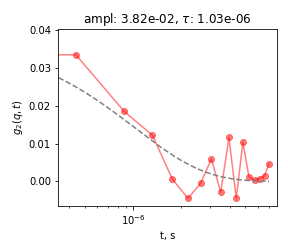

In [16]:
popt,xc,curve,perr = fit(exponential, time[:t_lim], g2[:t_lim]+1, p0=[.03,1e-5])
title = r'ampl: %.2e, $\tau$: %.2e' %tuple(popt)
        
# popt,xc,curve,perr = fit(exponential_kww, time[:t_lim], g2[:t_lim]+1, p0=[.03,1e-5,1.])
# title = 'ampl: %.2e, tau: %.2e \nkww: %.1f' %tuple(popt)

plt.figure(figsize=(4,3.5))

plt.plot(time[:t_lim], g2[:t_lim], 'o-', c='r', alpha=.5)
plt.plot(xc, curve-1, ls='--', c='gray')

plt.xlim(time[1]-1e-7, time[t_lim+1])
plt.xscale('log')
plt.xlabel('t, s')
plt.ylabel(r'$g_2(q,t)$')
plt.title(title)
plt.tight_layout()